#1) Connecting to GPU

In [ ]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}' .format(device_name))

2.11.0
Found GPU at: /device:GPU:0


This code checks the version of TensorFlow installed and then verifies if a GPU is available for TensorFlow to use. If a GPU is available, it will print "Found GPU at: /device:GPU:0". If not, it will raise a SystemError with the message "GPU device not found".

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

This code retrieves a list of all physical GPU devices available in the system using tf.config.experimental.list_physical_devices('GPU') and then loops over the GPUs. For each GPU, it sets the memory growth of the GPU to be True using tf.config.experimental.set_memory_growth(gpu, True). This means that TensorFlow will dynamically allocate memory on the GPU as it is needed, rather than pre-allocating all the memory at the start. This is useful when running large models that may not fit into GPU memory and allows for more efficient memory usage

#2) Loading and Preprocessing Data 

In [ ]:
import os
from PIL import Image
import numpy as np

def read_images(directory):
    images = []
    filenames = os.listdir(directory)
    filenames = sorted(filenames)
    for filename in filenames:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file = os.path.join(directory, filename)
            img = Image.open(file)
            # Preprocessing steps, such as resizing, normalizing, etc.
            img = img.resize((256, 256))  # Example of resizing to a common size
            if img.mode != "RGB":
                img = img.convert("RGB")
            img = np.array(img) / 255.0  # Normalize pixel values
            # Convert grayscale images to RGB
            img = np.expand_dims(img, axis=0) # Expanding to (None, 256, 256 ,3)
            images.append(np.array(img))
    return np.array(images)

input_images = read_images("input/")
output_images = read_images("output/")

In [ ]:
input_images.shape

(27, 1, 256, 256, 3)

This code defines a function read_images that takes in a directory and reads in the image files from that directory. The images are preprocessed in the following steps:

1.  Resizing to 256x256 pixels 
2.  Converting to RGB color mode (if the image is not already in RGB)
3. Normalizing the pixel values to be between 0 and 1 by dividing each pixel value by 255.0
4. Adding a batch dimension to the image by expanding the dimensions using **np.expand_dims**

The images are stored in a list and then converted to a NumPy array and returned by the function. The code then calls the **read_images** function twice, once for the **"input/"** directory and once for the **"output/"**
directory, and stores the results in the input_images and output_images variables, respectively.

#3) Visualizing our Dataset

In [ ]:
from matplotlib import pyplot as plt

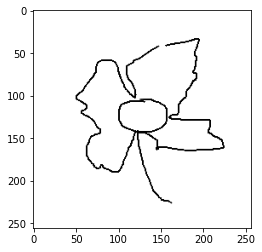

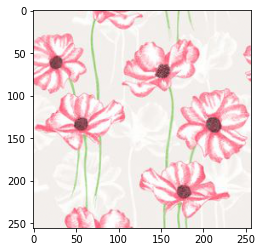

In [ ]:
plt.figure()
plt.imshow(np.squeeze(input_images[0]))
plt.figure()
plt.imshow(np.squeeze(output_images[0]))

#3) Building our Models

In [ ]:
import tensorflow as tf
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU, MaxPool2D, concatenate, Input

This code imports various functions and classes from TensorFlow's keras module, which is a high-level API for building and training deep learning models. The imported functions and classes are used for creating and defining the architecture of the generator and discriminator in a Generative Adversarial Network (GAN).



1.   **Sequential** is a model class in keras that allows you to create a linear stack of layers.
2.   **Conv2D** is a 2D convolutional layer that can extract local features from input images.
3. **Dense** is a fully connected layer that applies a dense connection to the input data.
4. **Flatten** is a layer that flattens the input tensor into a 2D array.
5. **Reshape** is a layer that reshapes the input tensor into a specified shape.
6. **ReLU** is an activation function that replaces negative values in the input with zeros.
7. **Dropout** is a regularization layer that randomly sets a portion of the input units to 0 during training to prevent overfitting.
8. **UpSampling2D** is a layer that upscales the input by a specified factor along both dimensions.
9. **Conv2DTranspose** is a transposed 2D convolutional layer that can be used for upscaling the input
10. **BatchNormalization** is a layer that normalizes the activations of the previous layer.
11. **Activation** is a layer that applies an activation function to the input.
12. **LeakyReLU** is an activation function that replaces negative values in the input with a small positive value.
13. **MaxPool2D** is a layer that performs max pooling, reducing the spatial dimensions of the input by a specified factor.
14. **concatenate** is a layer that concatenates multiple inputs along a specified axis.
15. **Input** is a layer that is used to instantiate a Keras tensor. It is a placeholder tensor that can be used as the input for a model.



In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

This code defines a function **upsample** that creates a **Sequential** model in TensorFlow's **keras** API. The model represents the upsampling part of a generator network in a Generative Adversarial Network (GAN).

The function takes three arguments: **filters**, **size**, and **apply_dropout**. **filters** specifies the number of filters to use in the **Conv2DTranspose** layer, **size** specifies the size of the filter to use, and apply_dropout is a Boolean flag that determines whether to **apply dropout** to the output of the model.

The **Sequential** model created by the function consists of the following layers:

1.   A **Conv2DTranspose** layer that upscales the input by a factor of 2 along both dimensions and applies filters filters of size size.
2.   A **BatchNormalization** layer that normalizes the activations of the previous layer.
3. A **Dropout** layer that randomly sets a portion of the input units to 0 during training to prevent overfitting. This layer is only applied if **apply_dropout is True**.
4. A **ReLU** activation layer that replaces negative values in the input with zeros.

The **Sequential** model is returned by the function.




In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

This code defines a function **downsample** that creates a **Sequential** model in TensorFlow's **keras** API. The model represents the downsampling part of a discriminator network in a Generative Adversarial Network (GAN).

The function takes three arguments: **filters**, **size**, and **apply_batchnorm**. **filters** specifies the number of filters to use in the **Conv2D** layer, **size** specifies the size of the filter to use, and **apply_batchnorm** is a Boolean flag that determines whether to apply batch normalization to the output of the model.

The **Sequential** model created by the function consists of the following layers:



1.   A **Conv2D** layer that downsamples the input by a factor of 2 along both dimensions and applies **filters** filters of **size** size.
2.   A **BatchNormalization** layer that normalizes the activations of the previous layer. This layer is only applied if **apply_batchnorm is True**.
3. A **LeakyReLU** activation layer that replaces negative values in the input with a small non-zero value to prevent the output from dying.

The **Sequential** model is returned by the function.



In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_images[0], 0))
down_result = tf.squeeze(down_result, axis=0)
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


##3.1) Building a Generator

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

This code defines the generator architecture for a GAN. The generator takes a noise vector as input and generates an image as output.

The architecture consists of two parts: a down-sampling path and an up-sampling path. The down-sampling path consists of multiple convolutional layers, which reduce the spatial resolution of the input image and increase the number of filters to extract higher-level features. The up-sampling path consists of transpose convolutional layers, which increase the spatial resolution of the feature map while reducing the number of filters. The two paths are connected by skip connections, which allow information to flow directly from the down-sampling path to the up-sampling path.

The final layer in the generator is a transpose convolutional layer with tanh activation, which generates the output image. The generator is defined as a Keras Model, which takes an input tensor and outputs the generated image.

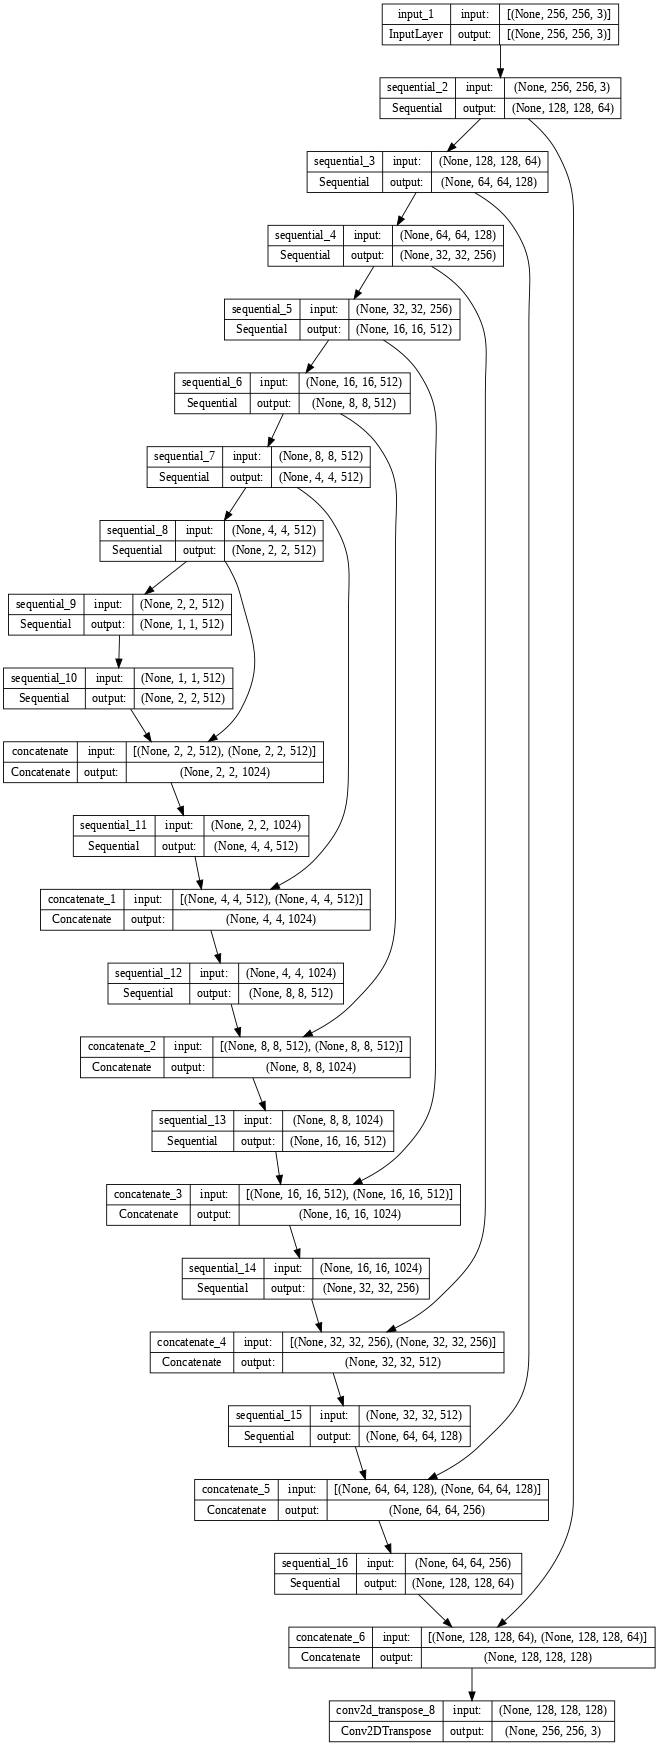

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

Testing our generator:

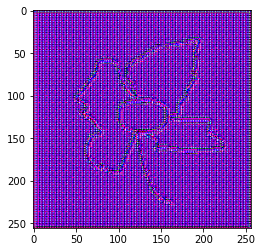

In [ ]:
gen_output = generator(input_images[0], training=False)
plt.imshow(gen_output[0, ...]*255)

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(tf.cast(target, tf.float32) - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Yes, that is correct! The **generator_loss** function is used to calculate the total loss of the generator network. The total loss is a combination of two different loss components: the GAN loss and the L1 loss.

The GAN loss is the cross-entropy loss between the output of the discriminator (**disc_generated_output**) and the target label of 1. This is because the generator wants the discriminator to classify its generated images as real (with a target label of 1).

The L1 loss is the mean absolute error between the generated images and the target images. The L1 loss is scaled by a hyperparameter **LAMBDA** that determines the relative importance of the L1 loss with respect to the GAN loss.

The final loss returned by the **generator_loss** function is the sum of the GAN loss and the scaled L1 loss.

##3.2) Building a Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

This defines a discriminator network using the Keras functional API. The discriminator takes as input a pair of images (the input and target images), concatenates them along the channels axis, and then performs several downsamplings to reduce the spatial resolution of the features. It then applies a series of Conv2D and batch normalization layers, followed by leaky ReLU activation functions, to produce a final output with a single channel representing the probability that the input pair is a real image pair.

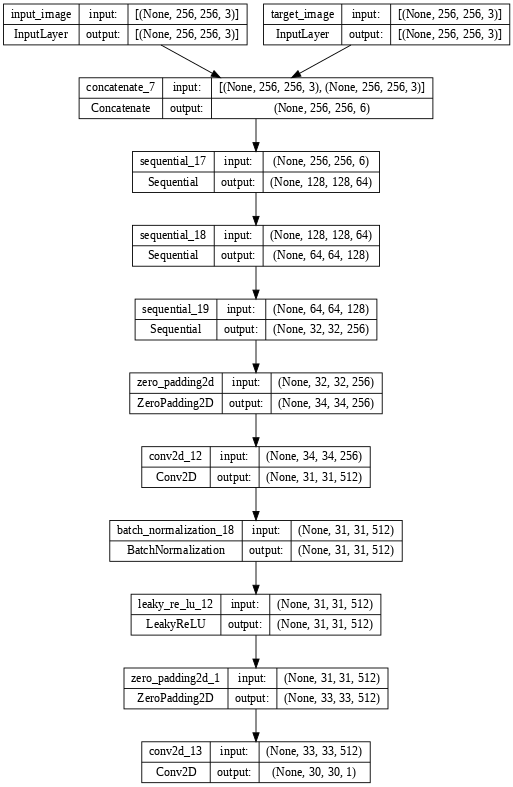

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

This function computes the total loss for the discriminator by adding the loss from real data and the loss from generated data.

Here, **disc_real_output** is the discriminator's prediction on real data and **disc_generated_output** is the discriminator's prediction on generated data. The loss_object is a loss function, such as binary cross-entropy.

For the real data, the target prediction is 1, so the loss is calculated as **real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)**. This represents the discriminator's confidence that the real data is real.

For the generated data, the target prediction is 0, so the loss is calculated as **generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)**. This represents the discriminator's confidence that the generated data is fake.

The total loss is the sum of **real_loss and generated_loss**, and this value is returned as **total_disc_loss**.

#4) Creating Custom Training Loop

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

This code defines two optimizers for the generator and discriminator models, respectively. The optimizer used is the Adam optimizer, which is a popular optimization algorithm for deep learning models. The learning rate is set to 2e-4 and the beta_1 parameter is set to 0.5. The learning rate determines the size of the step that the optimizer takes in the direction of the gradient. The beta_1 parameter is one of the parameters used in the calculation of the moving averages of the gradient.

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

The **generate_images** function generates and displays a comparison of input image, ground truth image, and predicted image using a model. The function takes in three arguments:

1. **model**: the model used for making predictions
2. **test_input**: a single batch of input images used to test the model
3. **tar**: the corresponding ground truth images of the input images

The function first calls the model on the **test_input** and saves the predicted images in the **prediction** variable. It then creates a plot using the **matplotlib** library, with a figure size of 15x15.

The **display_list** variable is a list of the input image, ground truth image, and predicted image, and the **title** variable contains the titles for each of these images. The loop iterates over the 3 images and adds each image to the plot. The image is displayed using the **imshow** function from matplotlib, and the pixel values are converted to the [0, 1] range using the formula **display_list[i] * 0.5 + 0.5**. The axis function is used to turn off the axis labeling for each image. Finally, the plot is displayed using the **show** function from **matplotlib**.

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #Generating image
    gen_output = generator(input_image, training=True)

    # Calculating from discriminator
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    #Calculating losses
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Calculating gradients
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  #Applying gradients
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

This code defines the training step for the generator and discriminator in a Generative Adversarial Network (GAN). The **train_step** function takes three arguments: **input_image**, **target**, and **step**.

1. **input_image** is a tensor representing the input image fed into the generator.
2. **target** is a tensor representing the target image that the generator aims to generate.
3. **step** is an integer representing the current training step, which is used to keep track of the training progress.
The function uses tf.GradientTape to record the computations for both the generator and the discriminator. The generator is first passed the input image, and its output is stored as gen_output. The real image and the generated image are then fed into the discriminator. The discriminator function returns two outputs: disc_real_output and disc_generated_output, which represent the predictions made by the discriminator for the real image and the generated image, respectively.

Next, the generator's total loss, GAN loss, and L1 loss are calculated using the generator_loss function. The discriminator's loss is also calculated using the discriminator_loss function. These losses are used to update the parameters of the generator and discriminator using the generator_optimizer and discriminator_optimizer optimizers, respectively.

Finally, the loss values are logged using tf.summary and a summary writer, so that they can be visualized using TensorBoard. The scalars are logged with the step value as the x-axis, which is the step//1000 value. This makes it easier to visualize the loss values during training and monitor the progress of the GAN.

#5) Training our GAN

In [ ]:
from IPython.display import clear_output

In [ ]:
import time
import random

In [ ]:
def fit(input_images, output_images, epochs):
  for i in range(epochs):
    for j in range(25):
      train_step(input_images[j], output_images[j], epochs)
    clear_output()
    print("After epoch: " + str(i))
    num = random.randint(0, 25)
    generate_images(generator,input_images[num],output_images[num])

After epoch: 999


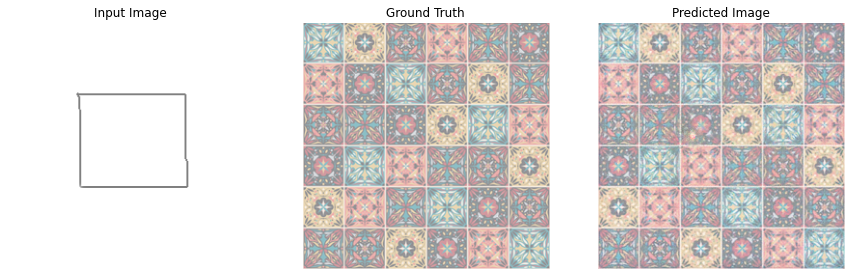

In [ ]:
fit(input_images, output_images, 1000)

In [ ]:
generator.save("./generator.h5")
discriminator.save("./discriminator.h5")

##6) Testing our GAN

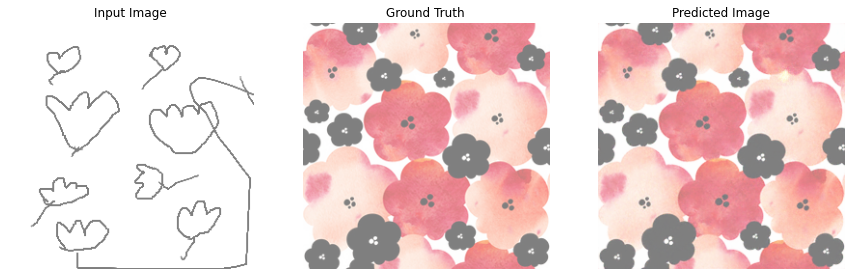

In [ ]:
generate_images(generator, input_images[16], output_images[16])

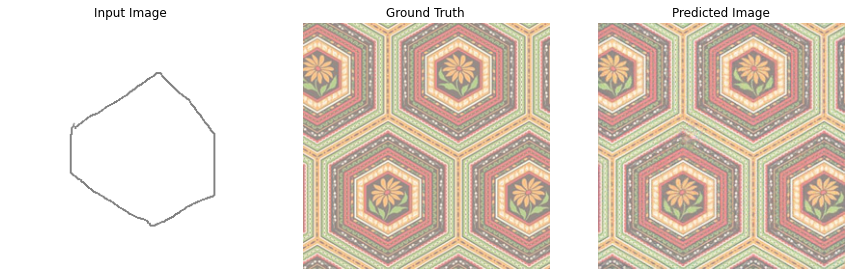

In [ ]:
generate_images(generator, input_images[2], output_images[2])

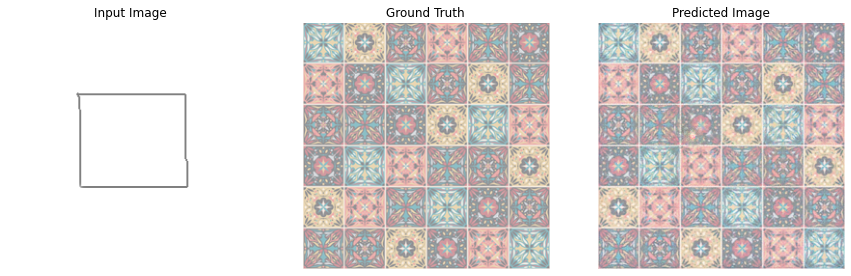

In [ ]:
generate_images(generator, input_images[3], output_images[3])

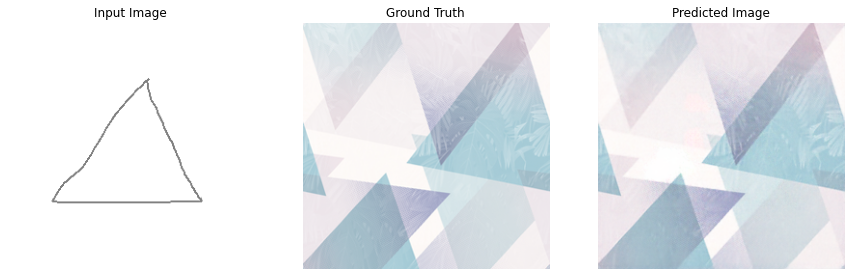

In [ ]:
generate_images(generator, input_images[4], output_images[4])

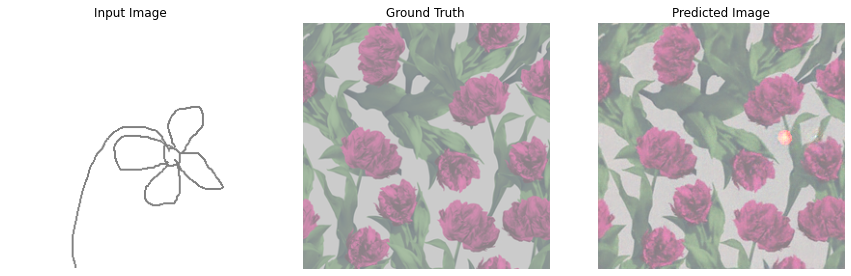

In [ ]:
generate_images(generator, input_images[5], output_images[5])

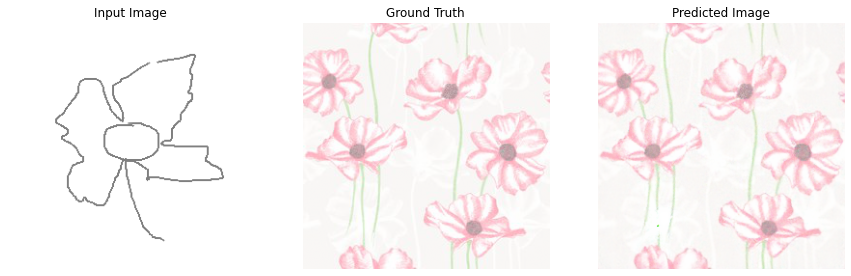

In [ ]:
generate_images(generator, input_images[0], output_images[0])